# ¡Hola, Ilse!  

Mi nombre es Carlos Ortiz, soy code reviewer de TripleTen y voy a revisar el proyecto que acabas de desarrollar.

Cuando vea un error la primera vez, lo señalaré. Deberás encontrarlo y arreglarlo. La intención es que te prepares para un espacio real de trabajo. En un trabajo, el líder de tu equipo hará lo mismo. Si no puedes solucionar el error, te daré más información en la próxima ocasión.

Encontrarás mis comentarios más abajo - **por favor, no los muevas, no los modifiques ni los borres**.

¿Cómo lo voy a hacer? Voy a leer detenidamente cada una de las implementaciones que has llevado a cabo para cumplir con lo solicitado. Verás los comentarios de esta forma:

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>
    
Si todo está perfecto.
</div>


<div class="alert alert-block alert-warning">
<b>Comentario del revisor</b> <a class="tocSkip"></a>
    
Si tu código está bien pero se puede mejorar o hay algún detalle que le hace falta.
</div>


<div class="alert alert-block alert-danger">
    
<b>Comentario del revisor</b> <a class="tocSkip"></a>
    
    
Si de pronto hace falta algo o existe algún problema con tu código o conclusiones.
</div>


Puedes responderme de esta forma:


<div class="alert alert-block alert-info">
<b>Respuesta del estudiante</b> <a class="tocSkip"></a>
</div>
¡Empecemos!

<div class="alert alert-block alert-info">
<b>Respuesta estudiante.</b> <a class="tocSkip"></a>
    Hola, espero que te encuentres muy bien. De entrada quiero darte las gracias por revisar mi proyecto, este especialmente me ha costado mas trabajo. He escrito comentarios con este mismo formato en algunas secciones que me gustaria que me apoyaras por favor. Yo estare al pendiente de tus observaciones y sugerencias. Muchas gracias y ten un bonito dia. Comparto el link del google colab en donde pude ejecutar perfectamente todo el proyecto incluido el modelo BERT.
    https://colab.research.google.com/drive/1ALPTA2inElYktikvmy3BCqD-i9vzPPDs?usp=sharing
</div>

# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [1]:
!pip install transformers torch scikit-learn

import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

import sklearn.metrics as metrics
import re
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, f1_score
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression


from nltk.corpus import stopwords
import spacy
from lightgbm import LGBMClassifier
import torch
import transformers

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [4]:
from google.colab import files
uploaded = files.upload()

df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>
    
Buen trabajo con la importación de datos y de librerías.
</div>

In [5]:
# imprimir informacion del dataframe
df_reviews.info()

In [6]:
# imprimir ejemplo del dataframe
print('Ejemplo del dataframe:\n',df_reviews.sample(3))

In [7]:
# verificar tipos de datos sean correspondientes a cada columna con la informacion de arriba
# tipo de datos a corregir: end_year a int64 y runtime_minutes a int64  pero antes sustituir valor \\N por cero
df_reviews['end_year'] = df_reviews['end_year'].replace({'\\N':0})
df_reviews['end_year'] = df_reviews['end_year'].astype(int)

df_reviews['runtime_minutes'] = df_reviews['runtime_minutes'].replace({'\\N':0})
df_reviews['runtime_minutes'] = df_reviews['runtime_minutes'].astype(int)

# verificar los tipos de datos de las columnas del dataframe
# print(df_reviews.dtypes)

In [8]:
# verificar si hay valores nulos aun en el dataframe
def reemplazar_nulos(df):
    for columna in df.columns:
        if df[columna].dtype == 'int64' or df[columna].dtype == 'Int64'or df[columna].dtype == 'float64':
            # Reemplazar valores nulos por 0 en columnas enteras
            df[columna] = df[columna].fillna(0)
        elif df[columna].dtype == 'object':
            # Reemplazar valores nulos por 'indeterminado' en columnas de tipo objeto
            df[columna] = df[columna].fillna('indeterminado')

    return df

df_reviews = reemplazar_nulos(df_reviews)

# contar cuantos valores nulos hay
# nulos_por_columna = df_reviews.isnull().sum()
# print("Valores nulos por columna:")
# print(nulos_por_columna)

In [9]:
def manejar_duplicados(df):
    # contar filas duplicadas
    duplicados_totales = df.duplicated().sum()
    print(f'Total de filas duplicadas: {duplicados_totales}')

    # elminar filas duplicadas
    sin_duplicados = df.drop_duplicates()
    print(f'Dataframe sin duplicados.')

    return sin_duplicados

df_reviews = manejar_duplicados(df_reviews)

## EDA

Veamos el número de películas y reseñas a lo largo de los años.

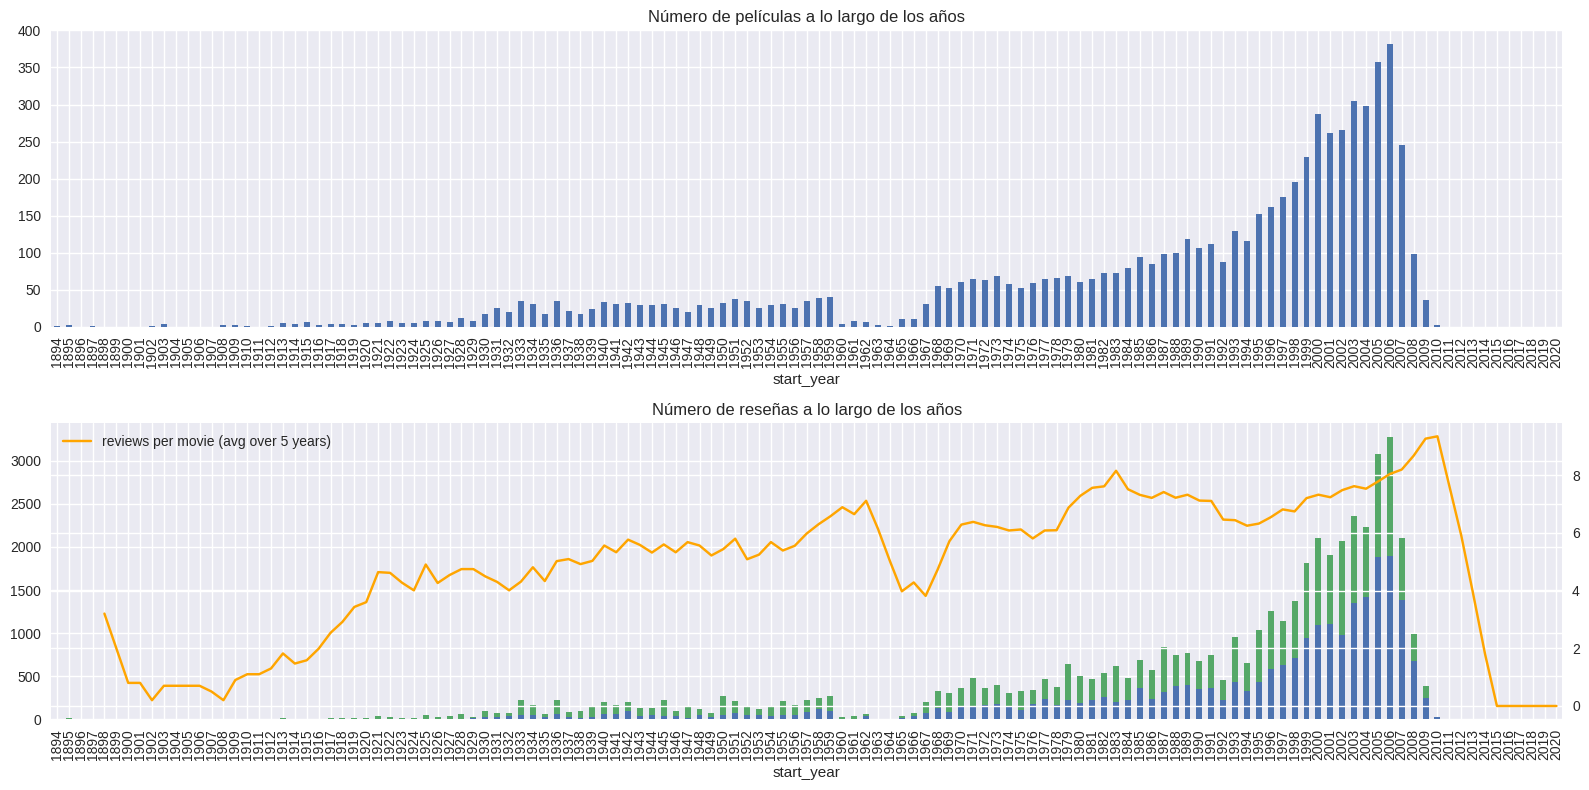

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

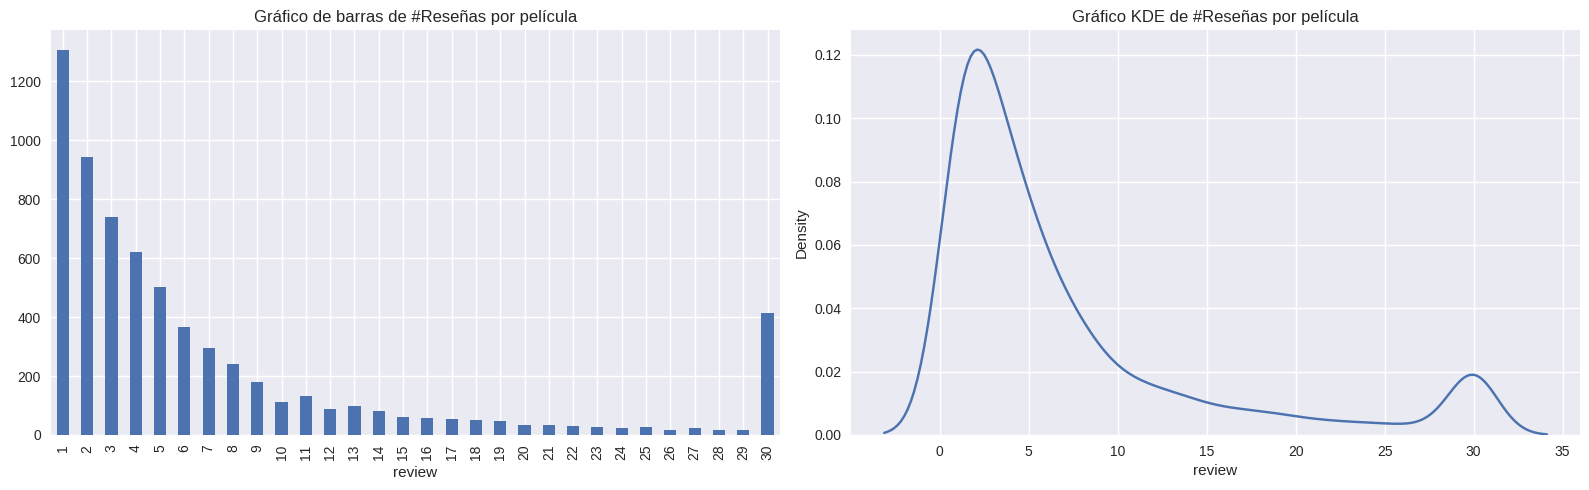

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

In [12]:
df_reviews['pos'].value_counts()

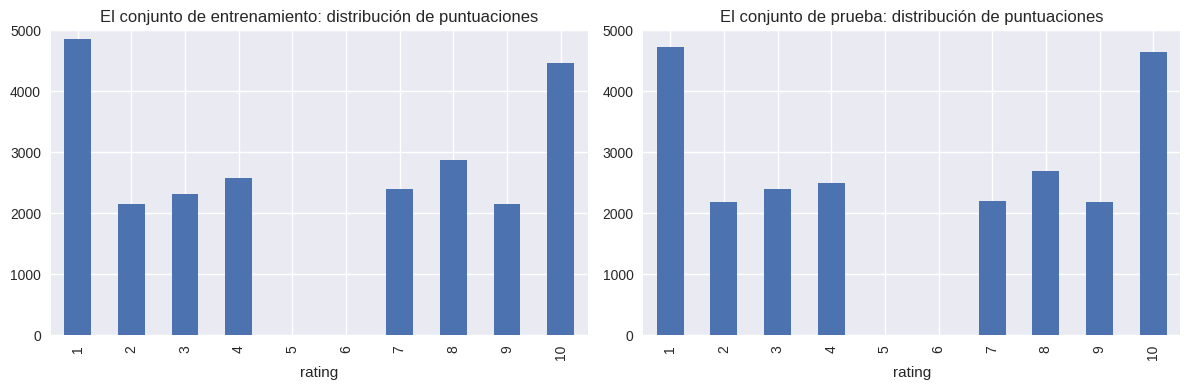

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

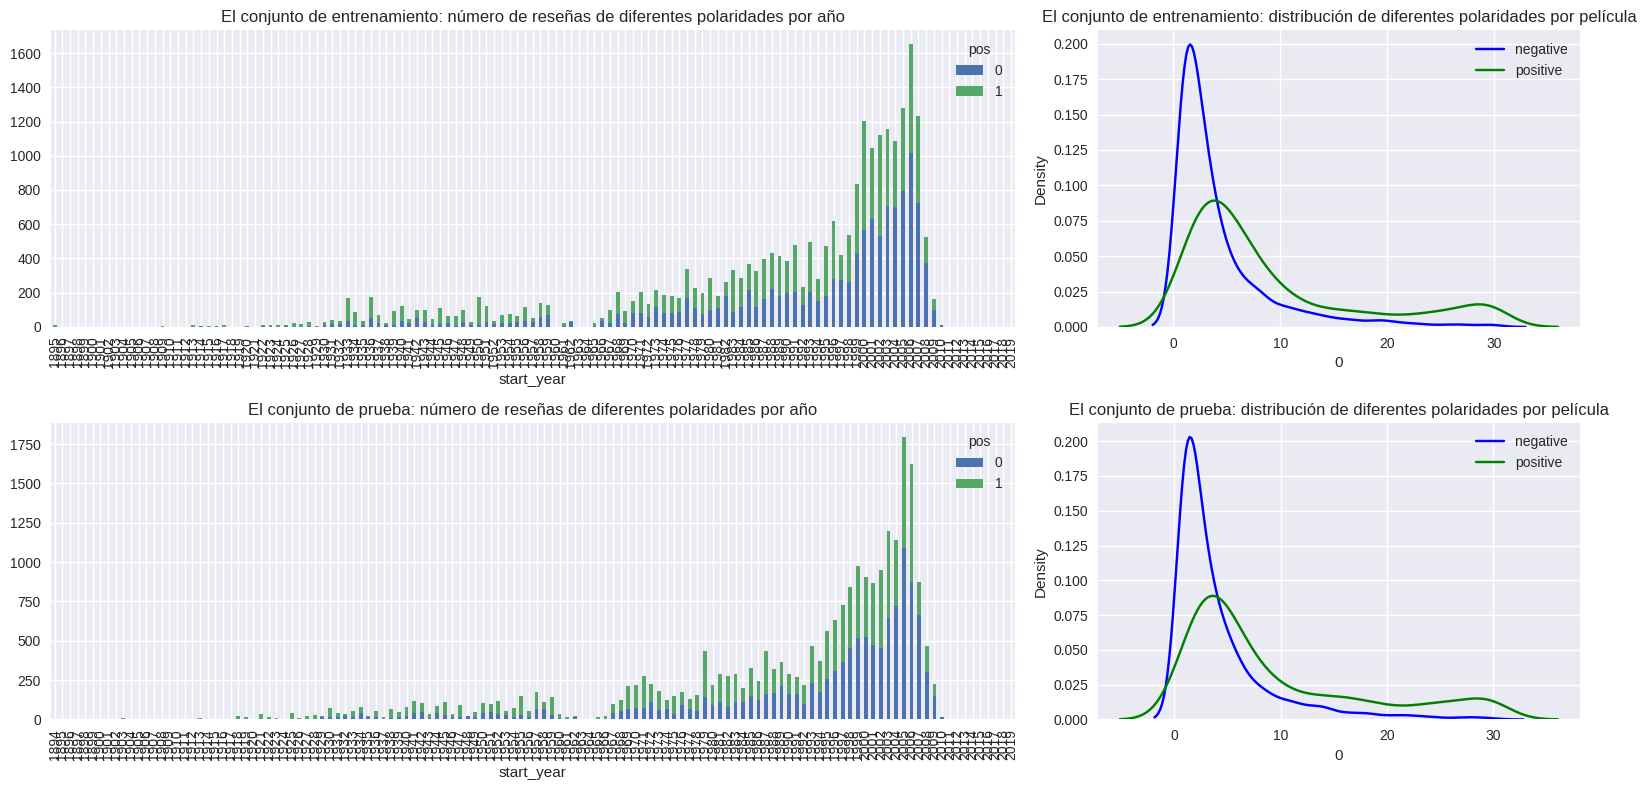

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

In [15]:
# pos: el objetivo, '0' para negativo y '1' para positivo

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>
    
Buen trabajo con esta exploración de los datos.
</div>

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [16]:
def evaluate_model(model, train_features, train_target, test_features, test_target):

    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba >= threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1')

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'Curva ROC')

        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    # Cambiar "Exactitud" por "Accuracy"
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    print(df_eval_stats)

    return df_eval_stats


## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [17]:
def clean_text(text):
    # convertir a minúsculas
    text = text.lower()
    # eliminar digitos y signos de puntuacion
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    return text

df_reviews['review_norm'] = df_reviews['review'].apply(clean_text)

## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [18]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

## Trabajar con modelos

### Modelo 0 - Constante

In [19]:
# caractersiticas del modelo, descartamos no solo la variable objetivo pos sino tambien aquellas columnas que no se necesiten en el analisis
features_train = df_reviews_train.drop(columns=['pos', 'ds_part','tconst', 'title_type', 'primary_title', 'idx'])
features_test = df_reviews_test.drop(columns=['pos', 'ds_part','tconst', 'title_type', 'primary_title', 'idx'])

In [20]:
# entrenar este modelo para que prediga cero es decir negativo
modelo_dummy = DummyClassifier(strategy='constant', constant=0)
# entrenar el modelo
modelo_dummy.fit(features_train, train_target)

# hacer predicciones y evaluar
y_pred = modelo_dummy.predict(features_test)
print(classification_report(test_target, y_pred))
print(f'F1 Score: {f1_score(test_target, y_pred, average="weighted"):.2f}')

In [21]:
# entrenar este modelo para que prediga uno es decir positivo
modelo_dummy = DummyClassifier(strategy='constant', constant=1)
# entrenar el modelo
modelo_dummy.fit(features_train, train_target)

# hacer predicciones y evaluar
y_pred = modelo_dummy.predict(features_test)
print(classification_report(test_target, y_pred))
print(f'F1 Score: {f1_score(test_target, y_pred, average="weighted"):.2f}')

### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [24]:
import nltk
# aplicar stopwords
nltk.download('stopwords')

# Obtener stopwords en ingles ya que la columna review_norm esta en ese idioma
#stop_words = set(stopwords.words('english'))
stop_words = list(set(stopwords.words('english')))

# aplicar TF_IDF
tfidf_vectorizer_1 = TfidfVectorizer(stop_words=stop_words)
# con la columna ya normalizada del paso 5 convertimos el texto en caracteristicas numericas
features_train_tfidf = tfidf_vectorizer_1.fit_transform(df_reviews_train['review_norm'])
features_test_tfidf = tfidf_vectorizer_1.transform(df_reviews_test['review_norm'])

# entrenar el modelo de regresion logistica
model_1 = LogisticRegression(max_iter=1000)  # max_iter aumentado por si el modelo necesita mas iteraciones
model_1.fit(features_train_tfidf, train_target)

# hacer predicciones y evaluar el modelo
y_pred = model_1.predict(features_test_tfidf)
print(classification_report(test_target, y_pred))
print(f'F1 Score: {f1_score(test_target, y_pred, average="weighted"):.2f}')

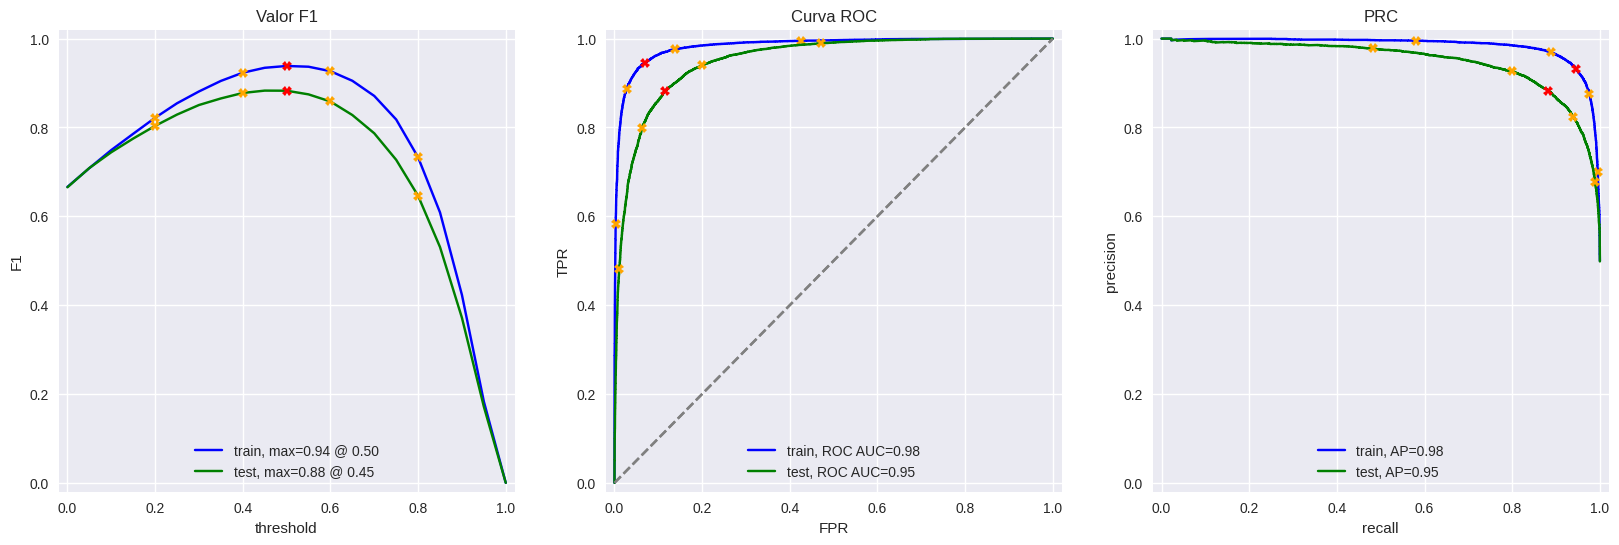

In [25]:
# evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)
# misma nomeclatura pero con los nombres que estableci en el modelo
evaluate_model(model_1, features_train_tfidf, train_target, features_test_tfidf, test_target)

### Modelo 3 - spaCy, TF-IDF y LR

In [26]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [27]:
def text_preprocessing_3(text):

    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    #tokens = [token.lemma_ for token in doc]

    return ' '.join(tokens)

<div class="alert alert-block alert-info">
<b>Respuesta estudiante.</b> <a class="tocSkip"></a>
    Aqui tengo un problema porque no logro correr las siguientes celdas, tardan mucho tiempo la celda del preprocesamiento de spaCy: df_reviews['review_processed'] = df_reviews['review_norm'].apply(text_preprocessing_3).
Si me pudieran señalar lo que no estoy haciendo bien te lo agradeceria muchisimo ya que este problema se extenderia tambien al siguiente modelo.
</div>

In [28]:
# aplicar preprocesamiento de texto a las reseñas ya normalizadas
df_reviews['review_processed'] = df_reviews['review_norm'].apply(text_preprocessing_3)

In [29]:
print(df_reviews.columns)

In [30]:
df_reviews_train = df_reviews[df_reviews['ds_part'] == 'train']
df_reviews_test = df_reviews[df_reviews['ds_part'] == 'test']

print(df_reviews_train.columns)
print('\n')
print(df_reviews_test.columns)

In [31]:
# aplicar TF-IDF solo a la columna de texto preprocesado
tfidf_vectorizer_3 = TfidfVectorizer()
features_train_tfidf = tfidf_vectorizer_3.fit_transform(df_reviews_train['review_processed'])
features_test_tfidf = tfidf_vectorizer_3.transform(df_reviews_test['review_processed'])

# Entrenar el modelo de Regresión Logística
model_3 = LogisticRegression(max_iter=1000)  # max_iter aumentado por si el modelo necesita mas iteraciones
model_3.fit(features_train_tfidf, train_target)

# Hacer predicciones y evaluar el modelo
y_pred = model_3.predict(features_test_tfidf)
print(classification_report(test_target, y_pred))
print(f'F1 Score: {f1_score(test_target, y_pred, average="weighted"):.2f}')

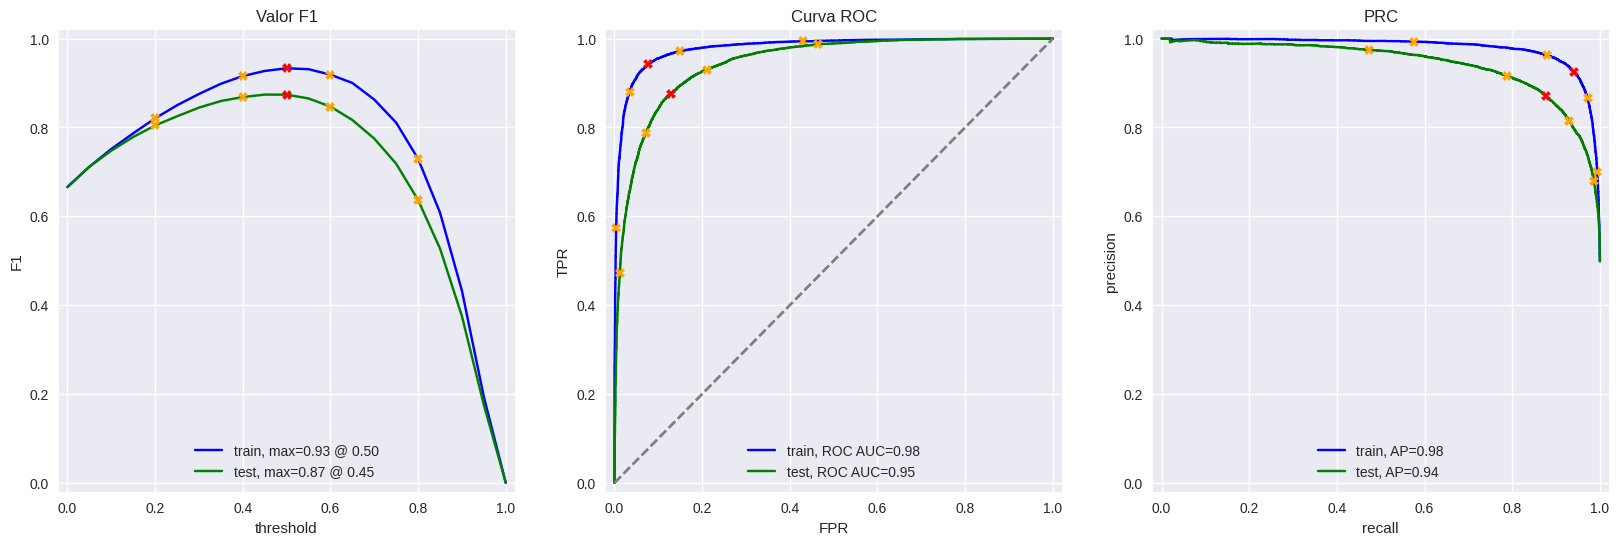

In [32]:
evaluate_model(model_3, features_train_tfidf, train_target, features_test_tfidf, test_target)

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [33]:
# aplicar TF-IDF
tfidf_vectorizer_4 = TfidfVectorizer()
features_train_tfidf = tfidf_vectorizer_4.fit_transform(df_reviews_train['review_processed'])
features_test_tfidf = tfidf_vectorizer_4.transform(df_reviews_test['review_processed'])

# entrenar el modelo LGBMClassifier
model_4 = LGBMClassifier()
model_4.fit(features_train_tfidf, train_target)

# hacer predicciones y evaluar
y_pred = model_4.predict(features_test_tfidf)
print(classification_report(test_target, y_pred))
print(f'F1 Score: {f1_score(test_target, y_pred, average="weighted"):.2f}')

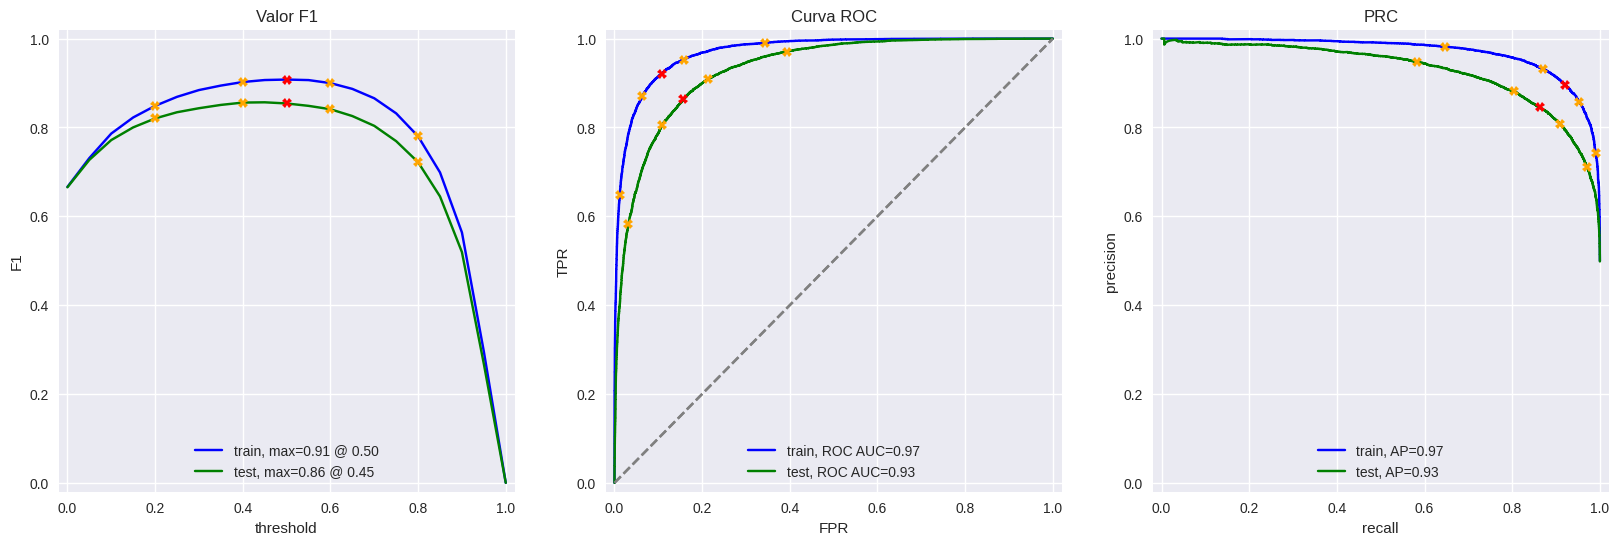

In [34]:
evaluate_model(model_4, features_train_tfidf, train_target, features_test_tfidf, test_target)

###  Modelo 9 - BERT

In [35]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [36]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):

    ids_list = []
    attention_mask_list = []

    # texto al id de relleno de tokens junto con sus máscaras de atención
    # <escribe tu código aquí para crear ids_list y attention_mask_list>
    for text in tqdm(texts, disable=disable_progress_bar):
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        ids_list.append(encoding['input_ids'].squeeze().tolist())
        attention_mask_list.append(encoding['attention_mask'].squeeze().tolist())
    #---------------
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)
    if not disable_progress_bar:
        print(f'Uso del dispositivo {device}.')

    # obtener insertados en lotes

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):

        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # <escribe tu código aquí para crear attention_mask_batch
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
        #---------------
        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())

    return np.concatenate(embeddings)

In [37]:
# ¡Atención! La ejecución de BERT para miles de textos puede llevar mucho tiempo en la CPU, al menos varias horas
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

<div class="alert alert-block alert-info">
<b>Respuesta estudiante.</b> <a class="tocSkip"></a>
    Hola el error que me salio aqui fue el siguiente: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx
Me gustaria si en esta parte me puede guiar mas ya que no estoy segura que GPU instalar. Si me pudiera compartir alguna liga no se de Youtube o instrucciones mas precisas lo agradeceria mucho. Por obvias razones las celdas de abajo no las corri.
</div>

<div class="alert alert-block alert-danger">
<b>Comentario del revisor</b> <a class="tocSkip"></a>
    
Esta parte no se puede correr si no se tiene una GPU. Por el momento, para este proyecto no se tiene una GPU disponible así que se puede pensar en dos soluciones:
    
1. Entrénalo en Google Colab y lo subes a la plataforma.
2. No es obligatorio emplearlo, así que también puedes eliminar esta sección.
</div>

<div class="alert alert-block alert-info">
<b>Respuesta estudiante.</b> <a class="tocSkip"></a>
    Hola, entonces no es necesario ejecutar esta seccion? No entendi muy bien. Si lo hago por aparte en Google Colab tendria que ejecutar las secciones de este modelo mas las necesarias donde he limpiado y normalizado el dataframe supongo, como puedo hacer eso? Si no es necesario para el proyecto esta bien, pero si me gustaria saber como se maneja. En caso de que haya algun video o link que me pudiera proporcionar lo agradeceria mucho.  
</div>

<div class="alert alert-block alert-danger">
<b>Comentario del revisor</b> <a class="tocSkip"></a>
    
Sí, tendrías que ejecutar todo el proyecto. Pero debes asegurarte de que el entorno de ejecución sea GPU. https://www.youtube.com/watch?v=FbC3hV5LQZ4
</div>

In [38]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

In [40]:
# Obtener embeddings para el conjunto de prueba
test_features_9 = BERT_text_to_embeddings(df_reviews_test['review_norm'], force_device='cuda')

In [41]:
print(df_reviews_test['review_norm'].shape)
print(test_features_9.shape)
print(test_target.shape)

In [42]:
# si ya obtuviste los insertados, te recomendamos guardarlos para tenerlos listos si
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# y cargar...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

# Guardar los embeddings en un archivo comprimido
np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# Cargar los embeddings desde el archivo comprimido
with np.load('features_9.npz') as data:
    train_features_9 = data['train_features_9']
    test_features_9 = data['test_features_9']


In [43]:
# calcular los embeddings para el conjunto de entrenamiento
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

# guardar los embeddings en un archivo comprimido
np.savez_compressed('features_9.npz', train_features_9=train_features_9)

In [44]:
# cargar los embeddings desde el archivo comprimido
with np.load('features_9.npz') as data:
    train_features_9 = data['train_features_9']

## Mis reseñas

In [45]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

my_reviews['review_norm'] = my_reviews['review'].apply(text_preprocessing_3)

# my_reviews

### Modelo 2

In [46]:
# model_2 = modelo_1? no hay modelo dos

model_2 = model_1
tfidf_vectorizer_2 = tfidf_vectorizer_1

texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### Modelo 3

In [47]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### Modelo 4

In [48]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### Modelo 9

In [51]:
# Entrenar el clasificador
classifier = LogisticRegression()
classifier.fit(train_features_9, train_target)

# Obtener los embeddings para las nuevas reseñas
texts = my_reviews['review_norm']
my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

# Predecir las probabilidades con el clasificador entrenado
my_reviews_pred_prob = classifier.predict_proba(my_reviews_features_9)[:, 1]

# Mostrar las probabilidades y las reseñas
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

## Conclusiones

En este proyecto, se aplicaron técnicas de procesamiento de lenguaje natural (NLP) para convertir reseñas de películas en un formato numérico, permitiendo clasificar automáticamente las reseñas como positivas o negativas. El objetivo principal fue desarrollar un modelo capaz de detectar críticas negativas con un valor de F1 Score de al menos 0.85.

Los resultados obtenidos demuestran que los modelos implementados (Modelo 1, Modelo 3 y Modelo 4) funcionan correctamente, logrando F1 Scores superiores a 0.85 tanto en el conjunto de entrenamiento como en el de prueba. En particular, el Modelo 1 alcanzó un F1 Score de 0.94 en entrenamiento y 0.88 en prueba, siendo el mejor desempeño entre los modelos evaluados. Estos resultados sugieren que las técnicas empleadas (como TF-IDF y regresión logística) son efectivas para identificar reseñas negativas en un conjunto de datos de reseñas de películas.

Sin embargo, el Modelo 9 BERT, aunque teóricamente prometedor, presentó dificultades en la implementación práctica, lo que indica la necesidad de mayor tiempo y recursos para optimizar su uso en este contexto.

El F1 Score es una métrica esencial en este tipo de tareas, ya que equilibra la precisión y el recall, asegurando que el modelo no solo sea preciso al clasificar correctamente las reseñas, sino que también capture la mayor cantidad posible de reseñas negativas sin generar muchos falsos positivos. Esto es crucial para sistemas que necesitan un rendimiento sólido en situaciones donde ambas clases (positiva y negativa) son igualmente importantes.

En conclusión, el proyecto logró satisfacer los objetivos propuestos, brindando un sistema capaz de filtrar y categorizar reseñas de manera eficiente, y estableciendo las bases para futuras mejoras, como la optimización del modelo BERT.



<div class="alert alert-block alert-danger">
<b>Comentario del revisor</b> <a class="tocSkip"></a>
    
Buen trabajo, Ilse. He dejado comentarios respondiendo a tus preguntas para poder terminar de resolver del proyecto.
</div>

<div class="alert alert-block alert-success">
    
# Comentarios generales
<b>Comentario del revisor</b> <a class="tocSkip"></a>
    
Todo corregido. Has aprobado un nuevo proyecto. ¡Felicitaciones!
</div>

# Lista de comprobación

- [x]  Abriste el notebook
- [ ]  Cargaste y preprocesaste los datos de texto para su vectorización
- [ ]  Transformaste los datos de texto en vectores
- [ ]  Entrenaste y probaste los modelos
- [ ]  Se alcanzó el umbral de la métrica
- [ ]  Colocaste todas las celdas de código en el orden de su ejecución
- [ ]  Puedes ejecutar sin errores todas las celdas de código
- [ ]  Hay conclusiones